In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from keras.callbacks import EarlyStopping

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve


from keras.models import Sequential
import tensorflow as tf
from keras import optimizers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard,CSVLogger
from keras.models import load_model

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)



Using TensorFlow backend.


In [2]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [3]:
# load  dataset
df = pd.read_csv('/home/francovm/Projects/SSE/data/processed/input_data.csv', sep='\t', encoding='utf-8')
df.head()

,x,n,u,Events
0,-12.28,-92.30,-9.23,0.0
1,-12.58,-92.54,-11.31,0.0
2,-13.16,-92.24,-8.02,0.0
3,-13.21,-92.20,-11.51,0.0
4,-12.92,-93.19,-10.20,0.0


In [4]:
input_X = df.loc[:, df.columns != 'Events'].values  # converts the df to a numpy array
input_y = df['Events'].values

n_features = input_X.shape[1]  # number of features

print(input_X.shape,input_y.shape)

(229716, 3) (229716,)


In [5]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y


In [6]:
# Temporalize the data
lookback = 40
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)



In [7]:
#Split into Test, valid and train

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [8]:
X_train_y0 = X_train[y_train==0.]
X_train_y1 = X_train[y_train==1.]

X_valid_y0 = X_valid[y_valid==0.]
X_valid_y1 = X_valid[y_valid==1.]

In [9]:
# Reshape the arrays

X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [10]:
y_train.shape

(146992,)

In [11]:
## To Categorical Data

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_valid = to_categorical(y_valid)

# print(y_valid.shape, y_test.shape, y_train.shape)

In [12]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
print(n_timesteps,n_features,n_outputs)

40 3 1


In [13]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

### Stardarization

In [14]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train))

In [15]:
# Standarize the input
X_train_y0_scaled = scale(X_train_y0, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)
X_test_scaled = scale(X_test, scaler)
X_train_scaled = scale(X_train, scaler)
X_valid_scaled = scale(X_valid, scaler)


### Test Standarization

In [16]:
a = flatten(X_train_scaled)
print('colwise mean', np.mean(a,axis=0).round(6))
print('colwise variance', np.var(a, axis=0))



colwise mean [ 0. -0.  0.]
colwise variance [1. 1. 1.]


# Model training

Training models (Use it)



In [ ]:
lr = 0.0001
verbose, epochs, batch_size = 1, 400, 64

In [ ]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(256, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(128, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(n_timesteps))
# Decoder
lstm_autoencoder.add(LSTM(128, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(256, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

In [ ]:
# adam = optimizers.Adam(lr)
# lstm_autoencoder.compile(loss='mse', optimizer=adam, metrics=['accuracy'])

# cp = ModelCheckpoint(filepath="/home/francovm/Projects/SSE/models/Autoencoder/big256-Autoencoder-classifier_LSTM_SSE_20window-stand.h5",
#                                save_best_only=True,
#                                verbose=0)

# tb = TensorBoard(log_dir='/home/francovm/Projects/SSE/models/Autoencoder/Tensorboard/big256-Autoencoder-classifier_LSTM_SSE_20window-stand',
#                 histogram_freq=0,
#                 write_graph=True,
#                 write_images=True)

# #set early stopping monitor so the model stops training when it won't improve anymore
# early_stopping_monitor = EarlyStopping(patience=5)

# csv_logger = CSVLogger('/home/francovm/Projects/SSE/data/Visualization/Data/big256-Autoencoder-classifier_LSTM_SSE_20window-stand.csv', append=True, separator=';')

# lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
#                                                 epochs=epochs, 
#                                                 batch_size=batch_size, 
#                                                 callbacks=[early_stopping_monitor,csv_logger,cp,tb],
#                                                 validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
#                                                 verbose=verbose)

In [ ]:
# list all data in history
print(lstm_autoencoder_history.history.keys())

# # summarize history for accuracy
plt.plot(lstm_autoencoder_history.history['accuracy'])
plt.plot(lstm_autoencoder_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.savefig('/home/francovm/Projects/SSE/data/Visualization/big256-LSTM-20days-acc-Autoencoder-classifier-stand.png')
plt.show()

# summarize history for loss
plt.plot(lstm_autoencoder_history.history['loss'])
plt.plot(lstm_autoencoder_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
 # Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.savefig('/home/francovm/Projects/SSE/data/Visualization/big256-LSTM-20days-loss-Autoencoder-classifier-stand.png')
plt.show()

# Save Model

In [17]:
# save model and architecture to single file

# lstm_autoencoder.save("/home/francovm/Projects/SSE/models/Autoencoder/LSTM_SSE_20days-Classification.h5")

# df = pd.DataFrame(lstm_autoencoder_history.history)

# df.to_csv( '/home/francovm/Projects/SSE/data/Visualization/Data/LSTM_SSE_20days_Autoencoder_Classification.csv',header=True)



# load model
model = load_model('/home/francovm/Projects/SSE/models/Autoencoder/Autoencoder-classifier_LSTM_SSE_40window-stand.h5')
# summarize model
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 40, 128)           67584     
_________________________________________________________________
lstm_26 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 40, 64)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 40, 64)            33024     
_________________________________________________________________
lstm_28 (LSTM)               (None, 40, 128)           98816     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 40, 3)             387       
Total params: 249,219
Trainable params: 249,219
Non-trainable params: 0
_______________________________________________

# Sanity check

Doing a sanity check by validating the reconstruction error on the train data. Here we will reconstruct the entire train data with both 0 and 1 labels.

**Expectation**: the reconstruction error of 0 labeled data should be smaller than 1.

**Caution**: do not use this result for model evaluation. It may result into overfitting issues.

In [ ]:
# train_x_predictions = model.predict(X_train_scaled)

In [ ]:

# mse = np.mean(np.power(flatten(X_train) - flatten(train_x_predictions), 2), axis=1)

# error_df = pd.DataFrame({'Reconstruction_error': mse,
#                         'True_class': y_train.tolist()})

# # error_df = error_df.reset_index()
# groups = error_df.groupby('True_class')

# fig, ax = plt.subplots()

# # print(np.reshape(group.index,140681,1), group.Reconstruction_error)
# for name, group in groups:
#     ax.plot(group.Reconstruction_error, marker='o', ms=3.5, linestyle='',label= "Break" if name == 1. else "Normal")

# ax.legend()
# plt.ylim(0,1)
# plt.title("Reconstruction error for different classes")
# plt.ylabel("Reconstruction error")
# plt.xlabel("Data point index")
# plt.show()



In [ ]:
# plt.plot(mse)

# Predictions using the Autoencoder

In [ ]:
valid_x_predictions = model.predict(X_valid_scaled)

# valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)

In [ ]:
# valid_x_predictions = lstm_autoencoder.predict(X_valid)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# Threshold 

In [ ]:
# plt.figure(figsize=(16,9),dpi=80)
# plt.title('loss Distribution', fontsize=16)
# sns.distplot(error_df['Reconstruction_error'],bins=100,kde=True,color='blue');
# plt.xlim([0.0,])

# loop

In [ ]:
# threshold=0
# f1=0
# recall=0
# accuracy=0
# while (recall < 0.5 or accuracy < 0.6):
#     print ('**************************')
#     print (threshold)
# #     threshold += .0005
#     threshold += 1000
#     y_pred = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
#     conf_matrix = confusion_matrix(error_df.True_class, y_pred)
#     tn, fp, fn, tp = conf_matrix.ravel()
#     precision = 1. * tp / (tp + fp)
#     recall = 1. * tp / (tp + fn)
#     f1 = (2 * recall * precision) / (recall + precision)
# # print ('**************************')
# # print (threshold)
#     print ('TP:' + str(tp))
#     print ('FP:' + str(fp))
#     print ('TN:' + str(tn))
#     print ('FN:' + str(fn))
#     accuracy = 1. * (tp + tn) / (tp + tn + fp + fn)
#     print ('Accuracy:' + str(accuracy))
#     print ('Precision:' + str(precision))
#     print ('Recall:' + str(recall))
#     print ('F1:' + str(f1))


In [18]:
test_x_predictions = model.predict(X_test_scaled)
# test_x_predictions = lstm_autoencoder.predict(X_test_scaled)

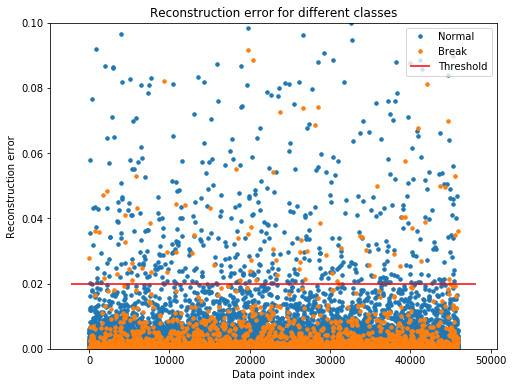

In [23]:
# test_x_predictions = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.02 # Definir!
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot( group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

ax.legend()
plt.ylim(0,0.1)
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [24]:
pred_y = [1. if e > threshold_fixed else 0. for e in error_df.Reconstruction_error.values]

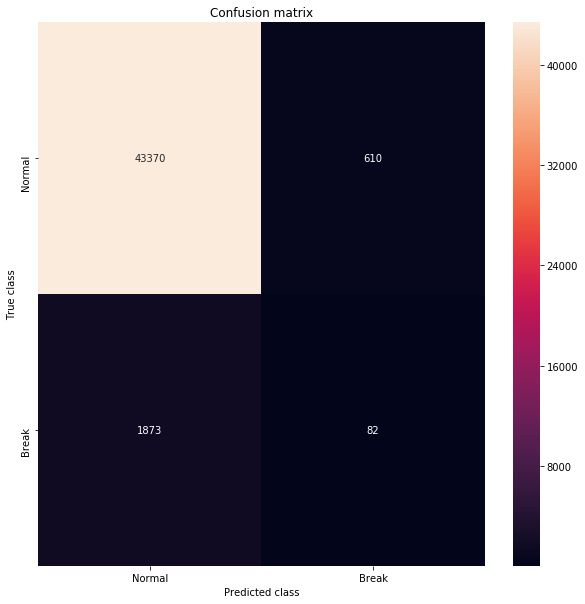

In [25]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(10, 10))
ax = sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
ax.set_ylim(2, 0)
plt.show()

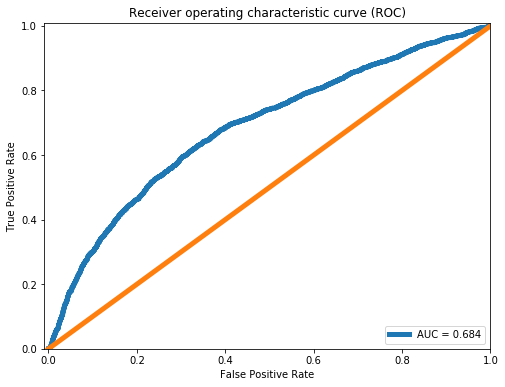

In [26]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


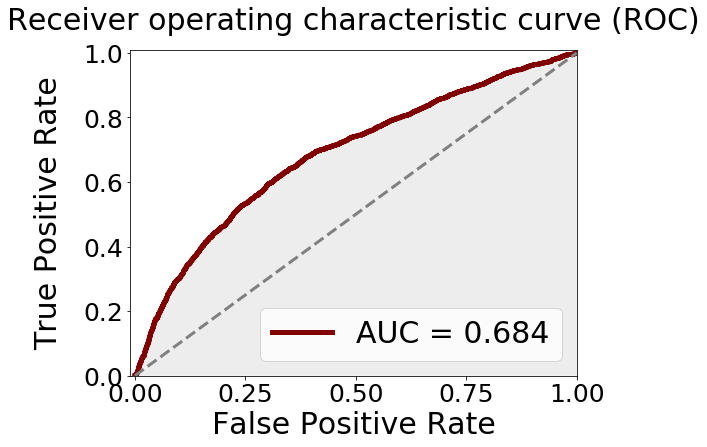

In [27]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc,color='maroon')
plt.plot([0,1],[0,1],'--', linewidth=3,color='gray')

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right',fontsize=30)
plt.title('Receiver operating characteristic curve (ROC)',fontsize=30, ha="center",pad=20)
plt.ylabel('True Positive Rate',fontsize=30,labelpad=20)
plt.xlabel('False Positive Rate',fontsize=30)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

           
ax = plt.subplot()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# set the grid on

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 25)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 25)

plt.fill_between( false_pos_rate, true_pos_rate, facecolor='lightgray',alpha=0.4)

# plt.axhline(y=0.952, color='r', linestyle='-')

plt.show()